In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
from keras.optimizers import adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import glob
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

Using TensorFlow backend.


In [72]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [2]:
# Retrieve the weights (50 epochs pre-training) of the projection head
!wget -q https://github.com/sayakpaul/SimSiam-TF/releases/download/v1.0.0/projection.h5

In [2]:
#load datset of Amahric charcters
# load the train and test datsets
x_train=np.load('x_train.npy')
x_test= np.load('x_test.npy')
y_train=np.load('y_train_231.npy')
y_test=np.load('y_test_231.npy')

In [3]:
# one-hoet-encoding of 231 classes
Y_train =np_utils.to_categorical(y_train, 231)
Y_test = np_utils.to_categorical(y_test, 231)

In [4]:
#load lables of the training and test datset interms of row/col
y_trainr=np.load('y_trainr.npy')
y_trainc=np.load('y_trainc.npy')
y_testr=np.load('y_testr.npy')
y_testc=np.load('y_testc.npy')

In [5]:
 #to find the fequnce of charcter image per class 
freqs = {}
for i in y_train:
    if i in freqs:
                freqs[i] += 1
                
    else:
        freqs[i] = 1

print(freqs)

{34: 317, 203: 306, 146: 307, 3: 324, 106: 312, 75: 293, 87: 322, 99: 321, 116: 290, 98: 299, 148: 267, 41: 270, 63: 312, 174: 309, 62: 324, 171: 320, 127: 297, 95: 332, 196: 311, 81: 339, 35: 279, 38: 302, 220: 315, 176: 324, 175: 328, 48: 317, 161: 305, 193: 345, 188: 295, 107: 347, 37: 277, 102: 295, 5: 300, 1: 306, 212: 330, 65: 316, 159: 320, 133: 356, 211: 316, 60: 300, 103: 307, 169: 328, 187: 324, 124: 337, 40: 326, 36: 303, 184: 368, 190: 314, 28: 320, 30: 338, 167: 310, 217: 278, 119: 301, 20: 341, 100: 332, 55: 341, 57: 313, 26: 322, 56: 307, 27: 308, 110: 286, 182: 297, 73: 320, 25: 313, 162: 324, 23: 287, 172: 289, 143: 302, 54: 310, 15: 314, 179: 302, 125: 324, 183: 307, 153: 319, 18: 318, 151: 338, 189: 314, 219: 334, 144: 301, 94: 302, 135: 309, 147: 295, 86: 304, 24: 297, 121: 306, 200: 278, 66: 334, 105: 330, 180: 326, 79: 281, 142: 308, 14: 309, 210: 320, 50: 308, 108: 304, 9: 271, 21: 310, 222: 307, 181: 290, 42: 347, 194: 314, 214: 305, 2: 309, 130: 309, 80: 309, 7

In [8]:
import collections
import statistics

In [9]:
images_per_class= collections.OrderedDict(sorted(freqs.items()))

In [10]:
images_per_class

OrderedDict([(0, 340),
             (1, 306),
             (2, 309),
             (3, 324),
             (4, 285),
             (5, 300),
             (6, 333),
             (7, 308),
             (8, 305),
             (9, 271),
             (10, 298),
             (11, 311),
             (12, 318),
             (13, 292),
             (14, 309),
             (15, 314),
             (16, 315),
             (17, 297),
             (18, 318),
             (19, 315),
             (20, 341),
             (21, 310),
             (22, 285),
             (23, 287),
             (24, 297),
             (25, 313),
             (26, 322),
             (27, 308),
             (28, 320),
             (29, 306),
             (30, 338),
             (31, 293),
             (32, 356),
             (33, 299),
             (34, 317),
             (35, 279),
             (36, 303),
             (37, 277),
             (38, 302),
             (39, 296),
             (40, 326),
             (41, 270),
  

In [24]:
x=images_per_class.keys()
y=images_per_class.values()

In [21]:
from imblearn.over_sampling import SMOTE

In [27]:
oversample = SMOTE()

In [6]:
# pprin the minmume/ maximum values  and its class label
print( {key:value for key, value in freqs.items() if value == (min(freqs.values()))})
print( {key:value for key, value in freqs.items() if value == (max(freqs.values()))})

{134: 262}
{72: 370}


In [6]:
# one-hoet-encoding of 231 classes
Y_train =np_utils.to_categorical(y_train, 231)
Y_test = np_utils.to_categorical(y_test, 231)

In [7]:
#just one-hot-encoding (row/col--33/7 class)
Y_trainr =np_utils.to_categorical(y_trainr, 33)
Y_testr = np_utils.to_categorical(y_testr, 33)

Y_trainc =np_utils.to_categorical(y_trainc, 7)
Y_testc = np_utils.to_categorical(y_testc, 7)

In [8]:
the encoder layer 
def get_encoder(tune_layer=0):
    base_model = tf.keras.applications.ResNet50(include_top=False,
        weights='imagenet', input_shape=(32, 32, 3))
    base_model.trainable = True
#      if tune_layer>0:
#         for layer in base_model.layers[:-tune_layer]:
#             layer.trainable=False
#     else:
#         for layer in base_model.layers:
#             layer.trainable = False
            
    inputs = tf.keras.layers.Input((32, 32, 3))
    xm = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(xm)
    x = tf.keras.layers.Dense(2048, activation='relu', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    z = tf.keras.layers.Dense(2048)(x)

    f = tf.keras.Model(inputs, z)

    return f, xm, base_model

In [20]:
get_encoder(0)[0].summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4194304   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
Total params: 31,986,560
Trainable params: 31,929,344
Non-trainable params: 57,216
__________________________________________

In [11]:
get_encoder(0)[2].summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [112]:
get_encoder(0)[2]
print("trainable_weights:", len(get_encoder(0)[2].trainable_weights))
print("non_trainable_weights:", len(get_encoder(0)[2].non_trainable_weights))

trainable_weights: 212
non_trainable_weights: 106


In [9]:
# We now load up the pre-trained weights
projection = get_encoder(0)[0]
projection.load_weights('projection.h5')

# Create a sub-model for extracting features
rn50 = tf.keras.Model(projection.input, projection.layers[2].output)
rn50.summary()

2022-05-13 17:52:00.089765: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [133]:
#231 classifier
def get_linear_classifier_231(feature_backbone, trainable=False):
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    
    feature_backbone.trainable =  trainable
    x = feature_backbone(inputs, training=False)
    outputs = tf.keras.layers.Dense(231, activation="softmax", )(x)
    linear_model = tf.keras.Model(inputs, outputs)

    return linear_model

In [134]:
get_linear_classifier_231(rn50).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_12 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 231)               473319    
Total params: 24,061,031
Trainable params: 473,319
Non-trainable params: 23,587,712
_________________________________________________________________


In [135]:
# Early Stopping to prevent overfitting and checkpoint to save model at each epoch231
early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=5, verbose=2, 
                                                 restore_best_weights=True)
checkpoint = ModelCheckpoint('./model_simsiam_231/modelSimsiam231{epoch:01d}.hdf5', period=1)

In [23]:
# Get linear model and compile 231
tf.keras.backend.clear_session()
model_231 = get_linear_classifier_231(rn50)
model_231.compile(loss="categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")



NameError: name 'get_linear_classifier_231' is not defined

In [12]:
#compile the model for row/col
tf.keras.backend.clear_session()
model_rc = get_linear_classifierrc(rn50)
model_rc.compile(loss=["categorical_crossentropy","categorical_crossentropy"], metrics=["accuracy"],
                     optimizer="adam")

In [29]:
model_rc.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model_3 (Functional)            (None, 2048)         23587712    input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 33)           67617       model_3[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 7)            14343       model_3[0][0]                    
Total params: 23,669,672
Trainable params: 81,960
Non-trainable params: 23,587,712
___________

In [ ]:
# Train 231
history = model_231.fit(x_train,Y_train,
                 validation_split=0.1,
                 other epochs=10,
                 callbacks=[early_stopper,checkpoint])


Epoch 1/10
 132/2025 [>.............................] - ETA: 1:14:01 - loss: 17807.6680 - accuracy: 0.0109

In [125]:
 model_231.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_12 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 231)               473319    
Total params: 24,061,031
Trainable params: 473,319
Non-trainable params: 23,587,712
_________________________________________________________________


In [125]:
score_231 = model_231.evaluate(x_test,Y_test,batch_size=16, verbose=1)

500/500 [==============================] - 14s 29ms/step - loss: 3080.2483 - accuracy: 0.6730


In [126]:
score_231

[3080.248291015625, 0.6729999780654907]

In [171]:
from sklearn.metrics import confusion_matrix

In [190]:
pred = model.predict(x_test)
y_pred = [np.argmax(p) for p in pred]

In [189]:
pred[0].shape

(33,)

In [2]:
# Train row/col 33/7
history = model_rc.fit(x_train,[Y_trainr,Y_trainc],
                 validation_split=0.1,
                 epochs=10,
                 callbacks=[early_stopper,checkpoint])

NameError: name 'model_rc' is not defined

In [1]:
score = model_rc.evaluate(x_test,[Y_testr,Y_testc],batch_size=16, verbose=1)

NameError: name 'model_rc' is not defined

In [20]:
print('Test lossr:', score[1])
print('Test lossc:', score[2])
print('Test accuracyr:', score[3])
print('Test accuracyc:', score[4])

Test lossr: 754.4881591796875
Test lossc: 643.5222778320312
Test accuracyr: 0.6974999904632568
Test accuracyc: 0.43312498927116394


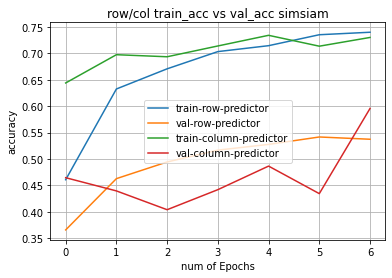

In [32]:
trr_acc = history.history['dense_accuracy']
valr_acc = history.history['dense_1_accuracy']
trc_acc = history.history['val_dense_accuracy']
valc_acc = history.history['val_dense_1_accuracy']
epochs=range(7)


# to print training  accuracy vs validation accuracy
plt.plot(epochs, trr_acc)
plt.plot(epochs, valr_acc)
plt.plot(epochs, trc_acc)
plt.plot(epochs, valc_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('row/col train_acc vs val_acc simsiam')
plt.grid(True)
plt.legend(['train-row-predictor', 'val-row-predictor','train-column-predictor', 'val-column-predictor'], loc='center')
plt.show()